In [193]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import norm
from sklearn import linear_model
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
import seaborn as sns

import regex as re
from sklearn.preprocessing import OneHotEncoder


In [144]:
df = pd.read_csv("houses_cleaned_baselineKNN.csv")
# df = pd.read_csv("houses_cleaned_baselineNanDropped.csv")

In [145]:
df

Unnamed: 0  final_price  bathrooms  parking  \
0               0       855000          2        1   
1               1       885000          2        6   
2               2       550000          1        0   
3               3       665000          1        1   
4               4       825513          2        1   
...           ...          ...        ...      ...   
15229       15229       785000          2        1   
15230       15230      1025000          5        2   
15231       15231       681000          3        1   
15232       15232       590000          1        0   
15233       15233       530000          2        4   

                                             description              type  \
0      Luxurious And Spacious Murano Tower. 2+1, 2 Ba...         Condo Apt   
1      Fantastic Opportunity To Live Within The Histo...     Semi-Detached   
2      Bright Sunfilled Spacious 1 Bdr Unit; Floor To...         Condo Apt   
3      Rare Loft-Like Condo In Liberty Village W/ 18'...         Condo Apt   
4      Location! Location! Location. Your Cottage In ...          Detached   
...                                                  ...               ...   
15229  Tableau Condo - Right In The Middle Of The Ent...         Condo Apt   
15230  New Years Special. Brand New House. Beautiful ...          Detached   
15231  Absolutely Beautiful **Freehold ** **End Unit*...  Att/Row/Twnhouse   
15232  One Year New Luxury Condo Built By Menkes. Hig...         Condo Apt   
15233  Great Builder Lot In Birchcliff Village. Can B...          Detached   

                                               full_link  \
0      https://www.zoocasa.com/toronto-on-real-estate...   
1      https://www.zoocasa.com/toronto-on-real-estate...   
2      https://www.zoocasa.com/toronto-on-real-estate...   
3      https://www.zoocasa.com/toronto-on-real-estate...   
4      https://www.zoocasa.com/toronto-on-real-estate...   
...                                                  ...   
15229  https://www.zoocasa.com/toronto-on-real-estate...   
15230  https://www.zoocasa.com/toronto-on-real-estate...   
15231  https://www.zoocasa.com/toronto-on-real-estate...   
15232  https://www.zoocasa.com/toronto-on-real-estate...   
15233  https://www.zoocasa.com/toronto-on-real-estate...   

                                         full_address        lat       long  \
0          38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
1              2 Cabot Crt, Toronto , Ontario, Canada  43.646982 -79.530356   
2        30 Roehampton Ave, Toronto , Ontario, Canada  43.708472 -79.397498   
3       65 East Liberty St, Toronto , Ontario, Canada  43.638399 -79.414448   
4            61 Twelfth St, Toronto , Ontario, Canada  43.597096 -79.509612   
...                                               ...        ...        ...   
15229         125 Peter St, Toronto , Ontario, Canada  43.648317 -79.393065   
15230      179 Raleigh Ave, Toronto , Ontario, Canada  43.706338 -79.262789   
15231    68 Stagecoach Cir, Toronto , Ontario, Canada  43.788258 -79.160342   
15232        365 Church St, Toronto , Ontario, Canada  43.660846 -79.378756   
15233        43 Kalmar Ave, Toronto , Ontario, Canada  43.691296 -79.268417   

                           city_district  mean_district_income  district_code  \
0                    Bay Street Corridor                 56526             76   
1             Islington-City Centre West                 52787             14   
2                    Mount Pleasant West                 57039            104   
3                                Niagara                 70623             82   
4                            New Toronto                 44101             18   
...                                  ...                   ...            ...   
15229  Waterfront Communities-The Island                 70600             77   
15230                Clairlea-Birchmount                 36232            120   
15231             Cent

### Data Exploration - Part 1

In [146]:
df_eda = df.copy(deep = True)

(25000.0, 200000.0)

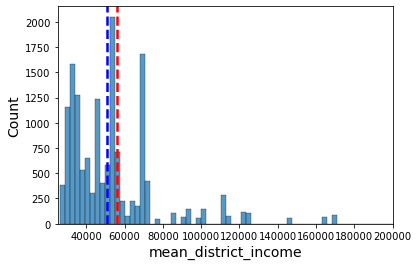

In [147]:
#Applicant income distribution
fig, ax = plt.subplots()

sns.histplot(df_eda['mean_district_income'],ax=ax)
ax.set_xlabel("mean_district_income", size=14)
ax.set_ylabel("Count", size=14)
ax.axvline(x=df.mean_district_income.median(),color='blue',ls='--',lw=2.5,label = 'median')
ax.axvline(x=df.mean_district_income.mean(),color='red',ls='--',lw=2.5, label = 'mean')
ax.set_xlim(25000,200000)

Condo Apt  -  7505


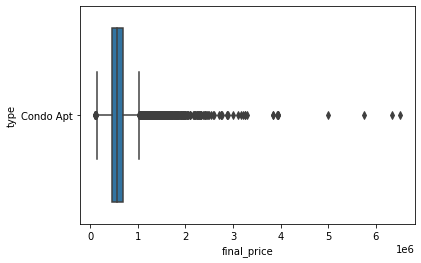

Condo Townhouse  -  1054


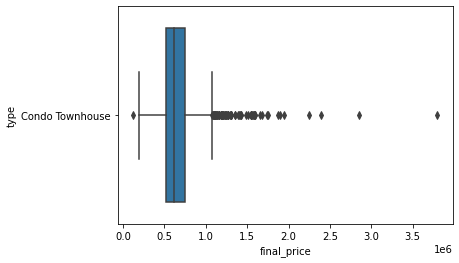

Comm Element Condo  -  181


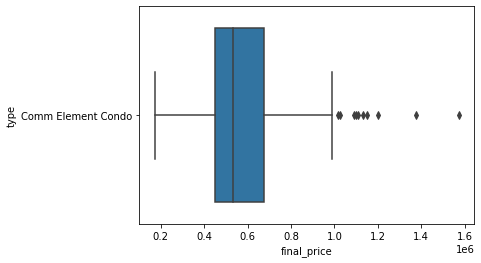

Detached  -  4348


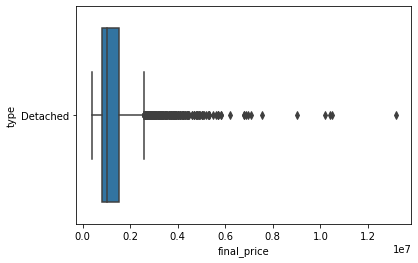

Semi-Detached  -  1393


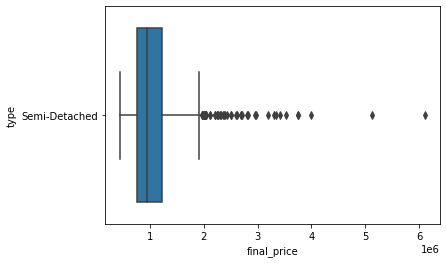

Att/Row/Twnhouse  -  452


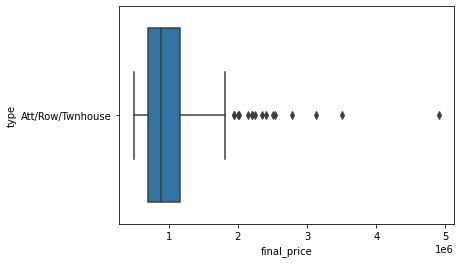

Co-Op Apt  -  24


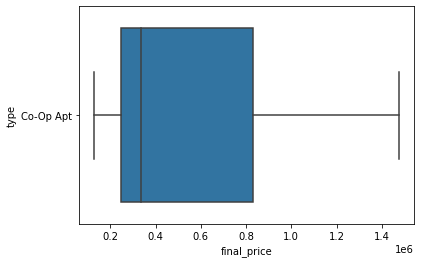

Co-Ownership Apt  -  27


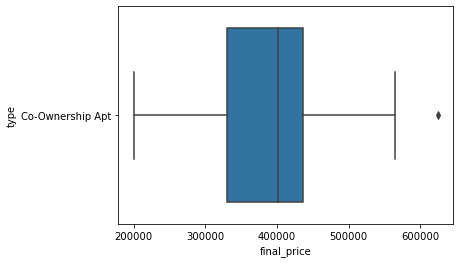

Plex  -  69


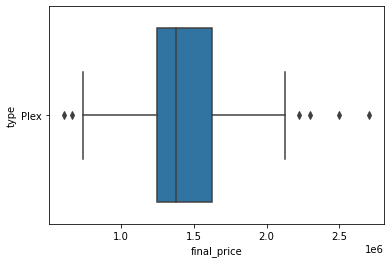

Link  -  27


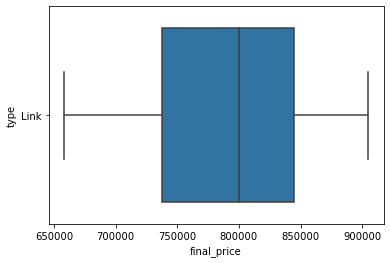

Store W/Apt/Offc  -  8


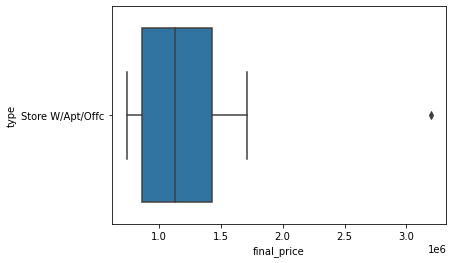

In [387]:
#Average price per house type

for i in df_eda.type.unique():
    
    print(i," - ", len(df_eda[df_eda['type'] == i]))
    print('average home price',df_eda.groupby('type').apply(me))
    sns.boxplot(y = df_eda[df_eda['type'] == i]['type'], x = df_eda.final_price)
    plt.show()

In [389]:
#most expensive home types
df_eda.groupby(['type'])['final_price'].agg('mean')

type
Att/Row/Twnhouse      9.959966e+05
Co-Op Apt             5.246309e+05
Co-Ownership Apt      3.854444e+05
Comm Element Condo    5.792189e+05
Condo Apt             6.246894e+05
Condo Townhouse       6.734446e+05
Detached              1.319050e+06
Link                  7.912593e+05
Plex                  1.454830e+06
Semi-Detached         1.057660e+06
Store W/Apt/Offc      1.367875e+06
Name: final_price, dtype: float64

In [440]:
#most expensive neighbourhoods
avg_price = df_eda.groupby(['Neighbourhood'])['final_price'].agg('mean').sort_values(ascending=True)
avg_price.loc['Mimico (includes Humber Bay Shores)']

710459.5717017208

In [433]:
#most listings by neighbourhood
df_eda.groupby(['Neighbourhood']).count().

Unnamed: 0  final_price  bathrooms  parking  \
Neighbourhood                                                               
Agincourt North                      106          106        106      106   
Agincourt South-Malvern West         164          164        164      164   
Alderwood                             60           60         60       60   
Annex                                194          194        194      194   
Banbury-Don Mills                    171          171        171      171   
...                                  ...          ...        ...      ...   
Wychwood                              69           69         69       69   
Yonge-Eglinton                        65           65         65       65   
Yonge-St.Clair                        72           72         72       72   
York University Heights              116          116        116      116   
Yorkdale-Glen Park                   104          104        104      104   

                              description  type  full_link  full_address  lat  \
Neighbourhood                                                                   
Agincourt North                       106   106        106           106  106   
Agincourt South-Malvern West          163   164        164           164  164   
Alderwood                              60    60         60            60   60   
Annex                                 194   194        194           194  194   
Banbury-Don Mills                     171   171        171           171  171   
...                                   ...   ...        ...           ...  ...   
Wychwood                               69    69         69            69   69   
Yonge-Eglinton                         65    65         65            65   65   
Yonge-St.Clair                         72    72         72            72   72   
York University Heights               115   116        116           116  116   
Yorkdale-Glen Park                    104   104        104           104  104   

                              long  ...  OBJECTID  Hood_ID  Shape__Area  \
Neighbourhood                       ...                                   
Agincourt North                106  ...       106      106          106   
Agincourt South-Malvern West   164  ...       164      164          164   
Alderwood                       60  ...        60       60           60   
Annex                          194  ...       194      194          194   
Banbury-Don Mills              171  ...       171      171          171   
...                            ...  ...       ...      ...          ...   
Wychwood                        69  ...        69       69           69   
Yonge-Eglinton                  65  ...        65       65           65   
Yonge-St.Clair                  72  ...        72       72           72   
York University Heights        116  ...       116      116          116   
Yorkdale-Glen Park             104  ...       104      104          104   

                              Shape__Length  Assault_Rate  Auto_Theft_Rate  \
Neighbourhood                                                                
Agincourt North                         106           106              106   
Agincourt South-Malvern West            164           164              164   
Alderwood                                60            60               60   
Annex                                   194           194              194   
Banbury-Don Mills                       171           171              171   
...                                     ...           ...              ...   
Wychwood                                 69            69               69   
Yonge-Eglinton                           65            65               65   
Yonge-St.Clair                           72            72               72   
York University Heights                 116           116              116   
Yorkdale-Glen Park                      104           104     

<AxesSubplot:xlabel='sqft', ylabel='final_price'>

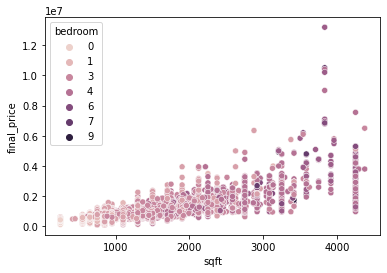

In [148]:
#Sqft vs Final Price wrt number of bedrooms
sns.scatterplot(x='sqft',y='final_price',hue='bedroom', data=df_eda)

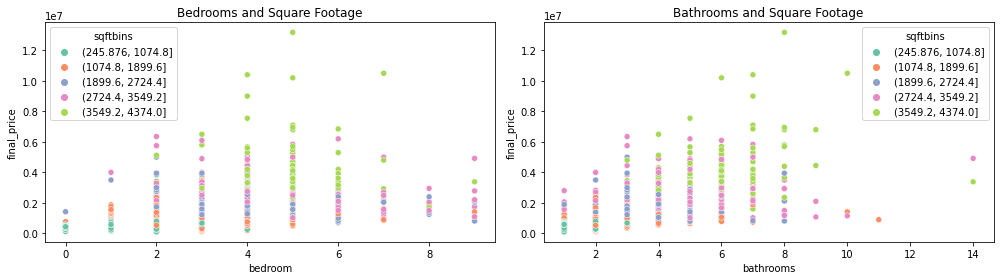

In [149]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))

df_eda['sqftbins'] = pd.cut(df_eda["sqft"], bins=5)
sns.scatterplot(data=df_eda, x="bedroom", y="final_price", hue="sqftbins", palette='Set2', ax=ax1)
ax1.set_title('Bedrooms and Square Footage')

sns.scatterplot(data=df_eda, x="bathrooms", y="final_price", hue="sqftbins", palette='Set2', ax=ax2)
ax2.set_title('Bathrooms and Square Footage')

plt.tight_layout()
plt.show()

<Figure size 1152x216 with 0 Axes>

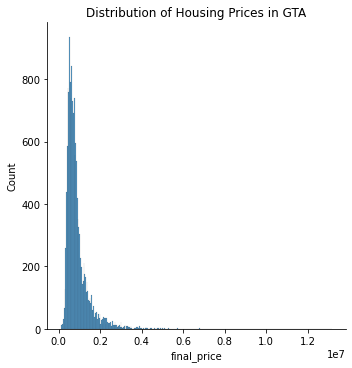

<Figure size 1152x216 with 0 Axes>

In [150]:
sns.displot(df_eda['final_price'])
plt.title('Distribution of Housing Prices in GTA')

plt.figure(5, figsize=[16,3])

C:\Users\bevli\anaconda3\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 720x720 with 0 Axes>

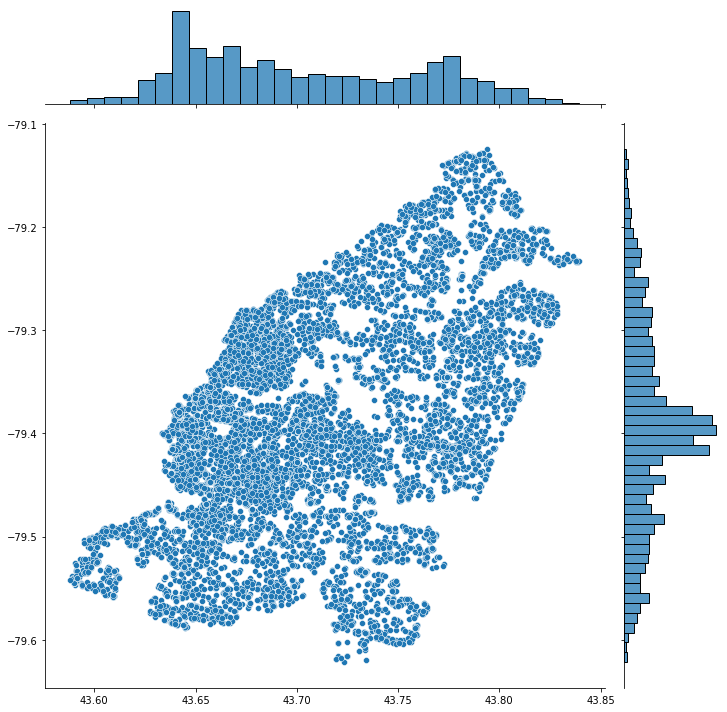

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [151]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df_eda.lat.values, y= df_eda.long.values, size = 10)
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()
sns.despine

C:\Users\bevli\AppData\Local\Temp/ipykernel_23048/4081054366.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  regions['neighbourhood'] = regions['FIELD_7'].str.replace(' \(.+\)', '')


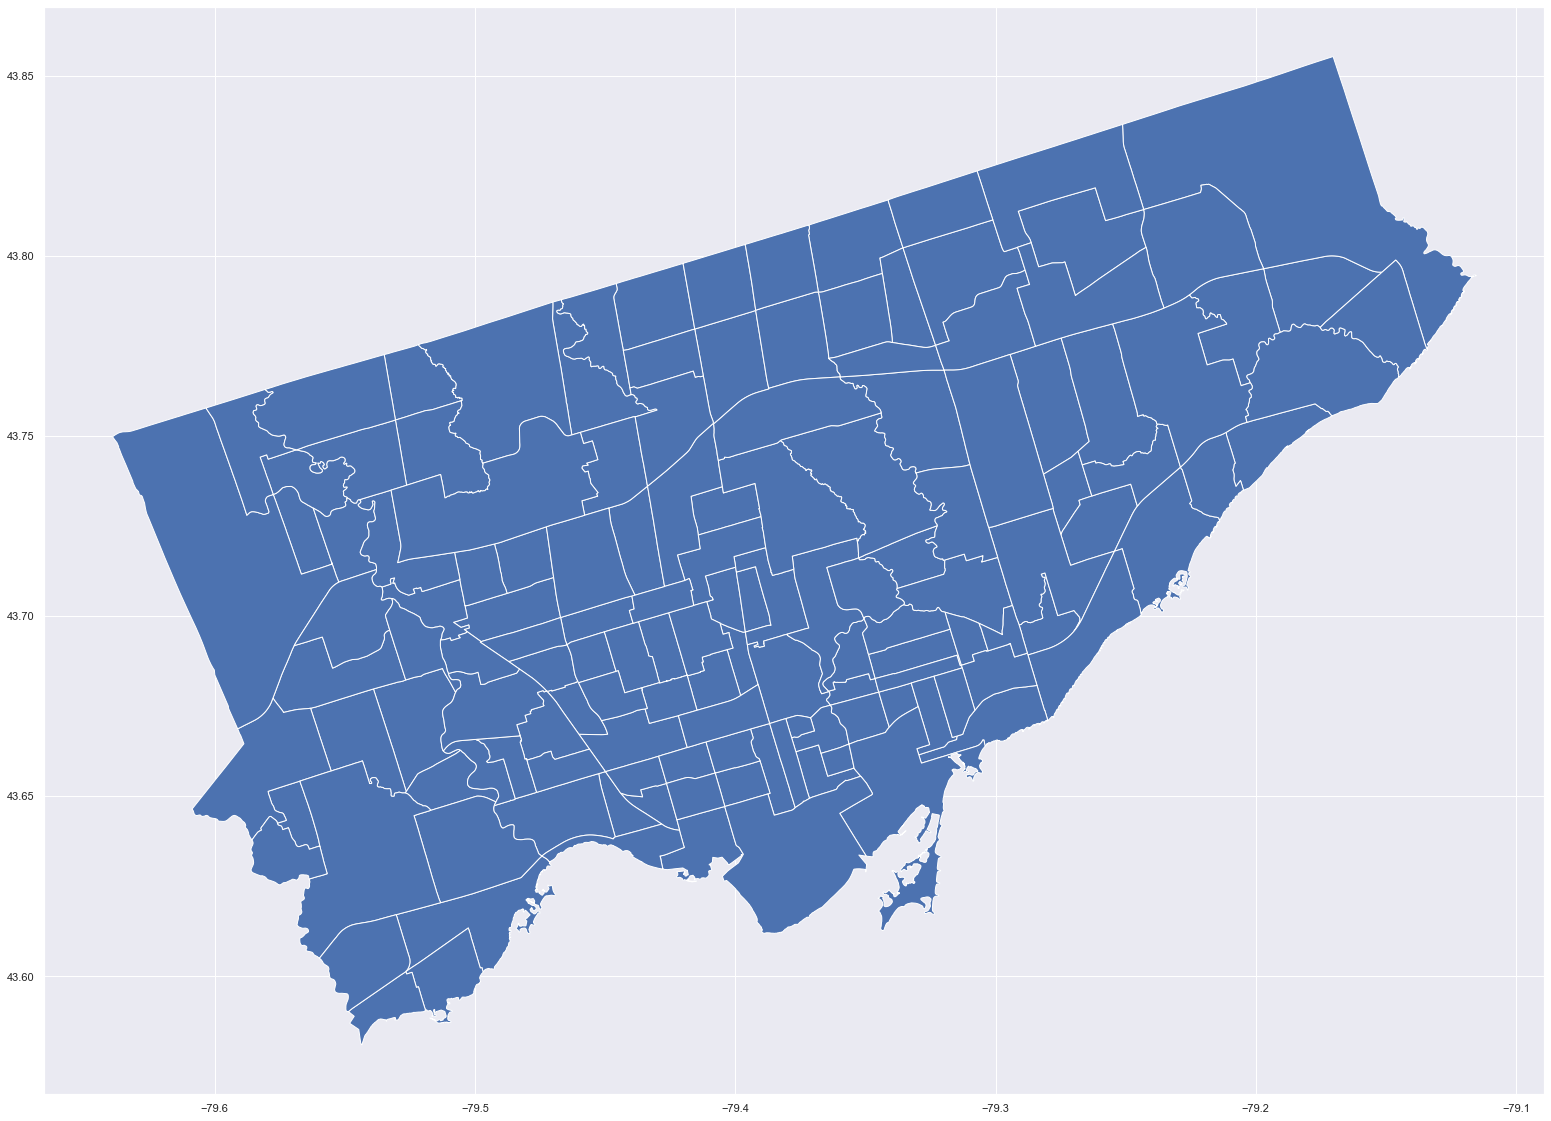

In [397]:
import geopandas as gpd
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

regions = gpd.read_file(r"C:\Users\bevli\Downloads\Final_Project_Lighthouse_Labs\Neighbourhoods - historical 140 - 4326\Neighbourhoods - historical 140.shp")
regions['neighbourhood'] = regions['FIELD_7'].str.replace(' \(.+\)', '')
regions.plot(figsize=(40,20))
plt.show()

In [398]:
df_eda['count'] = 1
dataByNeighbourhood = df_eda.groupby('Neighbourhood').count()[['count']].reset_index()
dataByNeighbourhood.sort_values('count', ascending=False).head(10)

Neighbourhood  count
120    Waterfront Communities-The Island   1148
86                               Niagara    533
76   Mimico (includes Humber Bay Shores)    523
126                      Willowdale East    453
57            Islington-City Centre West    417
22                 Church-Yonge Corridor    385
6                    Bay Street Corridor    276
72                               Malvern    254
82                   Mount Pleasant West    232
7                        Bayview Village    216

In [401]:
merged = regions.set_index('neighbourhood').join(dataByNeighbourhood.set_index('Neighbourhood'))

In [405]:
merged = merged.reset_index()
merged = merged.fillna(0)
merged[['neighbourhood', 'FIELD_11', 'geometry', 'count']].sample(5)

neighbourhood  FIELD_11  \
55   Englemount-Lawrence  17819249   
109      South Riverdale  17820113   
29      Newtonbrook West  17818833   
60           Morningside  17819329   
62            Maple Leaf  17819361   

                                              geometry  count  
55   POLYGON ((-79.43854 43.70586, -79.43855 43.705...   64.0  
109  POLYGON ((-79.32868 43.64745, -79.32867 43.647...  191.0  
29   POLYGON ((-79.44576 43.79241, -79.44335 43.792...  117.0  
60   POLYGON ((-79.22552 43.78925, -79.22549 43.789...   81.0  
62   POLYGON ((-79.49249 43.72010, -79.49185 43.720...   31.0

<AxesSubplot:title={'center':'Heat Map of Houses Sold by Neighbourhood in Toronto, Ontario'}>

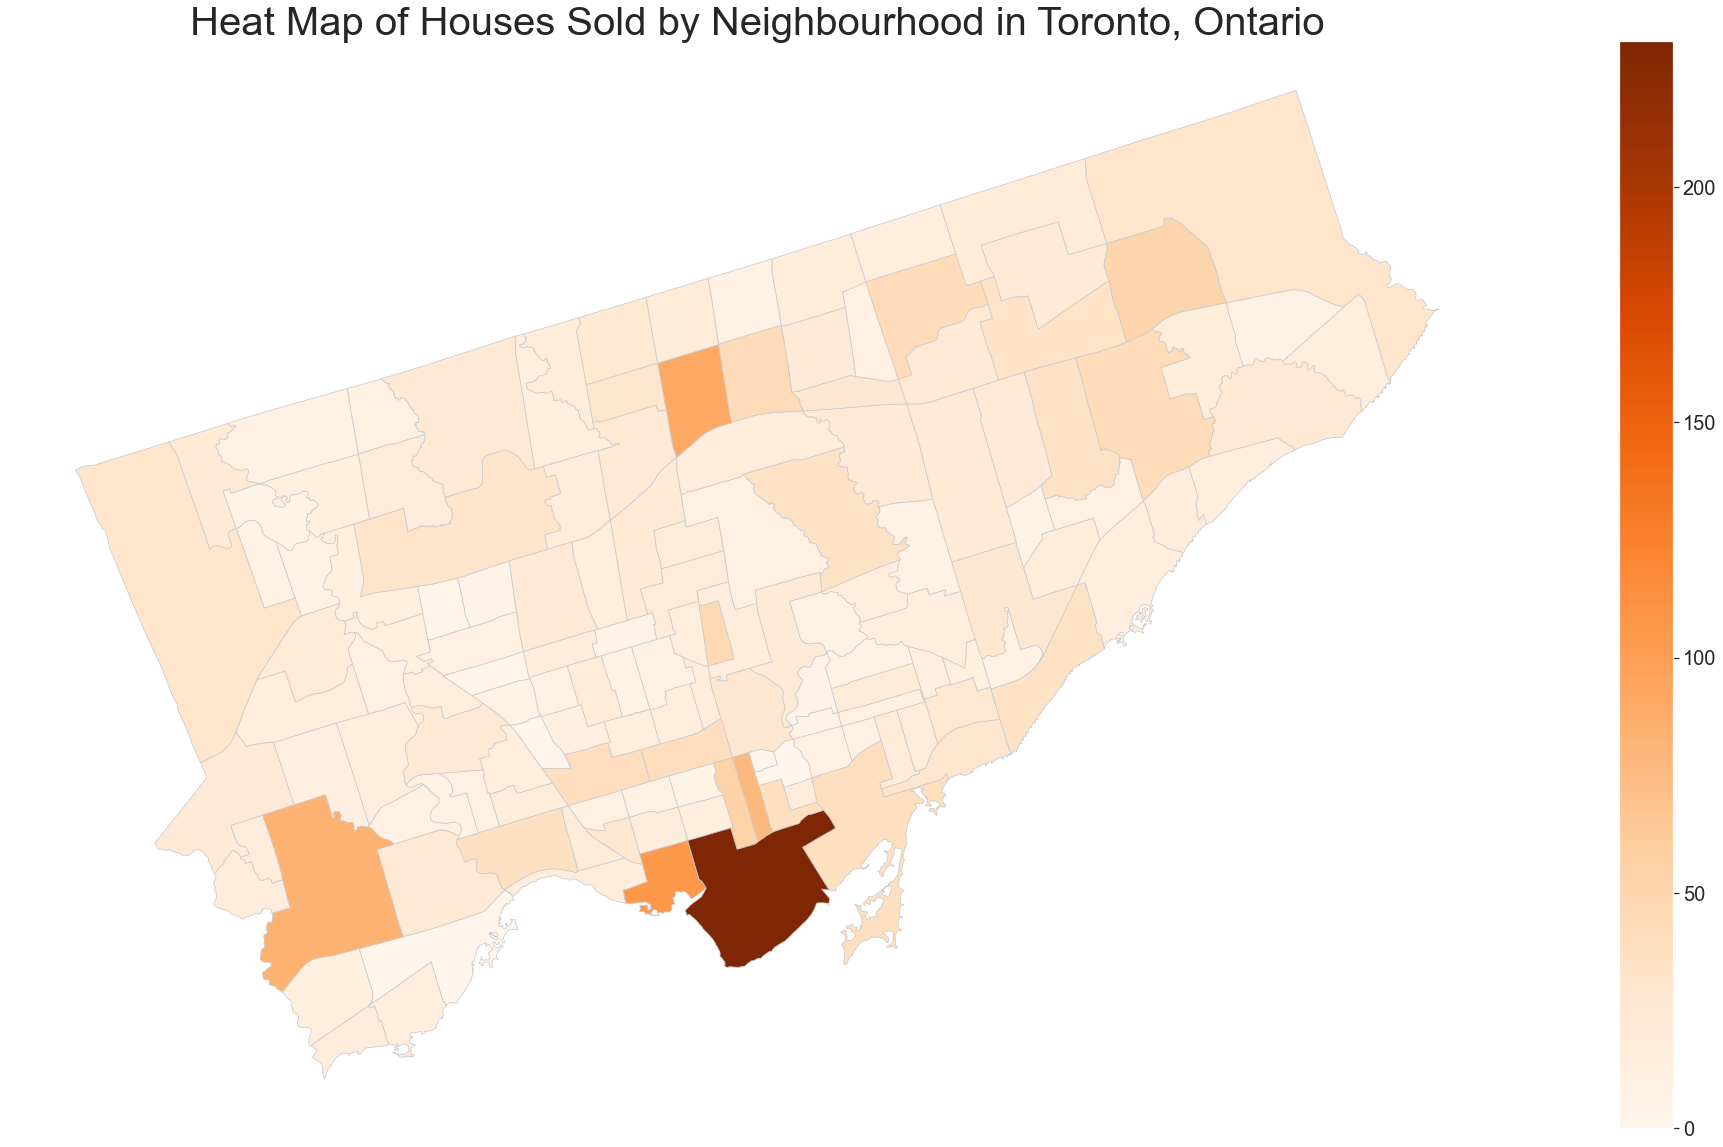

In [410]:
#plot the data
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Houses Sold by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

#make colour bar
color = 'Oranges'
vmin, vmax = 0, 231
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

merged.plot('count', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

In [424]:
#plotting individual datapoints

import pandas as pd
import plotly.express as px

fig = px.scatter_mapbox(
    df_eda,  # Our DataFrame
    lat = "lat",
    lon = "long",
    center = {"lat": 43.6532, "lon": -79.3832},  # where map will be centered
    width = 1500,  # Width of map
    height = 1500,  # Height of map
    hover_data = ["final_price"],  # what to display when hovering mouse over coordinate
)

fig.update_layout(mapbox_style="open-street-map") # adding beautiful street layout to map

fig.show()

In [418]:
#define bounding box
BBox = ((df_eda.long.min(), df_eda.long.max(),      
         df_eda.lat.min(), df_eda.lat.max()))
BBox

(-79.6216927, -79.1240938, 43.5881763, 43.8393717)

In [152]:
city_districts = df_eda.city_district.unique().tolist()

### Feature Engineering - Part 1

In [153]:
# Neighborhood crime rates obtained from data.torontopolice.on.ca
crime_df = pd.read_csv("Neighbourhood_Crime_Rates_2020.csv")

In [154]:
crime_df

OBJECTID                        Neighbourhood  Hood_ID  \
0           1                       Yonge-St.Clair       97   
1           2              York University Heights       27   
2           3                     Lansing-Westgate       38   
3           4                   Yorkdale-Glen Park       31   
4           5                  Stonegate-Queensway       16   
..        ...                                  ...      ...   
135       136                        Pleasant View       46   
136       137                             Wychwood       94   
137       138                   Leaside-Bennington       56   
138       139                 Briar Hill-Belgravia      108   
139       140  Mimico (includes Humber Bay Shores)       17   

     F2020_Population_Projection  Assault_2014  Assault_2015  Assault_2016  \
0                          14083            16            25            34   
1                          30277           273           298           363   
2                          18146            42            81            67   
3                          17560           106           137           175   
4                          27410            91            74            78   
..                           ...           ...           ...           ...   
135                        16856            34            45            56   
136                        16037            54            72            80   
137                        18627            41            30            38   
138                        15448            79            91            80   
139                        38739           208           206           242   

     Assault_2017  Assault_2018  Assault_2019  ...  Shootings_2020  \
0              25            28            35  ...               0   
1             351           362           382  ...              12   
2              84            68            70  ...               1   
3             163           178           210  ...              14   
4              98            86            83  ...               0   
..            ...           ...           ...  ...             ...   
135            54            46            51  ...               2   
136            54            74            69  ...               2   
137            38            36            32  ...               0   
138            75            91            81  ...               1   
139           339           487           324  ...               2   

     Shooting_Rate2014  Shootings_Rate2015  Shootings_Rate2016  \
0             0.000000            0.000000            7.722008   
1             6.963789            0.000000           13.986990   
2             0.000000            0.000000            5.980146   
3            19.740740           19.752440           19.700550   
4            11.702290            7.788465            0.000000   
..                 ...                 ...                 ...   
135           0.000000           18.367720            6.139866   
136           0.000000            6.798097            0.000000   
137           0.000000            0.000000            0.000000   
138           6.781040            0.000000            6.792094   
139           0.000000            8.931762            2.839054   

     Shootings_Rate2017  Shootings_Rate2018  Shootings_Rate2019  \
0              0.000000            0.000000            0.000000   
1             34.504170           27.189610           20.102520   
2              0.000000            5.737564           11.245430   
3             44.312210           61.042610          100.170900   
4              3.821754            3.759257            3.702744   
..                  ...                 ...                 ...   
135            6.087539            6.035367            0.000000   
136            0.000000            6.481721            6.357279   
137            0.000000            0.000000            0.000000   
138    

In [155]:
#dropping data from 2019 to 2020 as dataset has houses from 2018

crime_df = crime_df[crime_df.columns.drop(list(crime_df.filter(regex='2019')))]
crime_df = crime_df[crime_df.columns.drop(list(crime_df.filter(regex='2020')))]

In [156]:
#Finding averages from 2014 to 2018 for each crime metric and adding to dataframe
crime_df['Assault_Rate'] = crime_df[['Assault_Rate2014',
       'Assault_Rate2015', 'Assault_Rate2016', 'Assault_Rate2017',
       'Assault_Rate2018']].mean(axis = 1)

crime_df['Auto_Theft_Rate'] = crime_df[[ 'AutoTheft_Rate2014', 'AutoTheft_Rate2015', 'AutoTheft_Rate2016',
       'AutoTheft_Rate2017', 'AutoTheft_Rate2018']].mean(axis = 1)

crime_df['Break_andEnter_Rate'] = crime_df[['BreakAndEnter_Rate2014',
       'BreakAndEnter_Rate2015', 'BreakAndEnter_Rate2016',
       'BreakAndEnter_Rate2017', 'BreakAndEnter_Rate2018']].mean(axis = 1)

crime_df['Robbery_Rate'] = crime_df[[ 'Robbery_Rate2014', 'RobberyRate_2015', 'Robbery_Rate2016',
       'Robbery_Rate2017', 'Robbery_Rate2018']].mean(axis = 1)

crime_df['Shootings_Rate'] = crime_df[['Shooting_Rate2014', 'Shootings_Rate2015', 'Shootings_Rate2016',
       'Shootings_Rate2017', 'Shootings_Rate2018']].mean(axis = 1)

In [157]:
crime_df.drop(columns = ['Assault_2014', 'Assault_2015',
       'Assault_2016', 'Assault_2017', 'Assault_2018', 'Assault_Rate2014',
       'Assault_Rate2015', 'Assault_Rate2016', 'Assault_Rate2017',
       'Assault_Rate2018', 'AutoTheft_2014', 'AutoTheft_2015',
       'AutoTheft_2016', 'AutoTheft_2017', 'AutoTheft_2018',
       'AutoTheft_Rate2014', 'AutoTheft_Rate2015', 'AutoTheft_Rate2016',
       'AutoTheft_Rate2017', 'AutoTheft_Rate2018', 'BreakAndEnter_2014',
       'BreakAndEnter_2015', 'BreakAndEnter_2016', 'BreakAndEnter_2017',
       'BreakAndEnter_2018', 'BreakAndEnter_Rate2014',
       'BreakAndEnter_Rate2015', 'BreakAndEnter_Rate2016',
       'BreakAndEnter_Rate2017', 'BreakAndEnter_Rate2018', 'Robbery_2014',
       'Robbery_2015', 'Robbery_2016', 'Robbery_2017', 'Robbery_2018',
       'Robbery_Rate2014', 'RobberyRate_2015', 'Robbery_Rate2016',
       'Robbery_Rate2017', 'Robbery_Rate2018', 'TheftOver_2014',
       'TheftOver_2015', 'TheftOver_2016', 'TheftOver_2017', 'TheftOver_2018',
       'TheftOver_Rate2014', 'TheftOver_Rate2015', 'TheftOver_Rate2016',
       'TheftOver_Rate2017', 'TheftOver_Rate2018', 'Homicide_2014',
       'Homicide_2015', 'Homicide_2016', 'Homicide_2017', 'Homicide_2018',
       'Homicide_Rate2014', 'Homicide_Rate2015', 'Homicide_Rate2016',
       'Homicide_Rate2017', 'Homicide_Rate2018', 'Shootings_2014',
       'Shootings_2015', 'Shootings_2016', 'Shootings_2017', 'Shootings_2018',
       'Shooting_Rate2014', 'Shootings_Rate2015', 'Shootings_Rate2016',
       'Shootings_Rate2017', 'Shootings_Rate2018'],inplace = True, axis = 1)

In [158]:
#check if both dataframes have the exact same neighbourhoods

for i in range(140):
    if (sorted(city_districts)[i] == sorted(crime_df.Neighbourhood)[i]):
        pass
    else:
        print (sorted(city_districts)[i]," - ", sorted(crime_df.Neighbourhood)[i])


Cabbagetown-South St. James Town  -  Cabbagetown-South St.James Town
North St. James Town  -  North St.James Town
Weston-Pelham Park  -  Weston-Pellam Park


In [159]:
df["city_district"].replace({"Cabbagetown-South St. James Town": "Cabbagetown-South St.James Town", "North St. James Town": "North St.James Town", "Weston-Pelham Park": "Weston-Pellam Park"}, inplace=True)

In [160]:
#merging crime DataFrame to EDA DataFrame and original DataFrame
df_eda = pd.merge(df_eda, crime_df, left_on=['city_district'],right_on=['Neighbourhood'], how = 'inner')
df = pd.merge(df, crime_df, left_on=['city_district'],right_on=['Neighbourhood'], how = 'inner')

In [161]:
df

Unnamed: 0  final_price  bathrooms  parking  \
0               0       855000          2        1   
1              85       785000          1        1   
2             154       718000          2        0   
3             161       968000          2        1   
4             216       650000          2        1   
...           ...          ...        ...      ...   
15229       11499      1430000          5        2   
15230       12791       900000          3        4   
15231       14732       805000          4        2   
15232       14950       740000          4        4   
15233       15140       798000          4        4   

                                             description       type  \
0      Luxurious And Spacious Murano Tower. 2+1, 2 Ba...  Condo Apt   
1      Five Condos - Stunning Bright Corner Unit In A...  Condo Apt   
2      Spacious 2 Bedrooms, 2 Full Baths, Over 1000 S...  Condo Apt   
3      Beautiful Burano On Bay Is A Diamond In The Sk...  Condo Apt   
4      *Smart & Functional One Bdrm + Den + Extra Bat...  Condo Apt   
...                                                  ...        ...   
15229  Custom Built! Brand New Never Been Lived!Cover...   Detached   
15230  Immaculate 4 Bed, 3 Bath Raised Bungalow With ...   Detached   
15231  4 Bedroom, 4 Washroom Home In Prestigious High...   Detached   
15232  You Will Love The Location Of This All Brick F...   Detached   
15233  Spacious Immaculate 4 Bedroom In A Prestigious...   Detached   

                                               full_link  \
0      https://www.zoocasa.com/toronto-on-real-estate...   
1      https://www.zoocasa.com/toronto-on-real-estate...   
2      https://www.zoocasa.com/toronto-on-real-estate...   
3      https://www.zoocasa.com/toronto-on-real-estate...   
4      https://www.zoocasa.com/toronto-on-real-estate...   
...                                                  ...   
15229  https://www.zoocasa.com/toronto-on-real-estate...   
15230  https://www.zoocasa.com/toronto-on-real-estate...   
15231  https://www.zoocasa.com/toronto-on-real-estate...   
15232  https://www.zoocasa.com/toronto-on-real-estate...   
15233  https://www.zoocasa.com/toronto-on-real-estate...   

                                       full_address        lat       long  \
0        38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
1         5 St Joseph St, Toronto , Ontario, Canada  43.665753 -79.385579   
2             633 Bay St, Toronto , Ontario, Canada  43.656674 -79.383443   
3             832 Bay St, Toronto , Ontario, Canada  43.661927 -79.386511   
4       111 Elizabeth St, Toronto , Ontario, Canada  43.655055 -79.384721   
...                                             ...        ...        ...   
15229       33 Cosens St, Toronto , Ontario, Canada  43.796526 -79.173685   
15230       57 Watson St, Toronto , Ontario, Canada  43.786423 -79.173985   
15231      44 Fishery Rd, Toronto , Ontario, Canada  43.791859 -79.175068   
15232   76 Muirbank Blvd, Toronto , Ontario, Canada  43.795167 -79.158194   
15233        4 Lavery Tr, Toronto , Ontario, Canada  43.794767 -79.162195   

       ... OBJECTID        Neighbourhood  Hood_ID   Shape__Area  \
0      ...       94  Bay Street Corridor       76  1.809355e+06   
1      ...       94  Bay Street Corridor       76  1.809355e+06   
2      ...       94  Bay Street Corridor       76  1.809355e+06   
3      ...       94  Bay Street Corridor       76  1.809355e+06   
4      ...       94  Bay Street Corridor       76  1.809355e+06   
...    ...      ...                  ...      ...           ...   
15229  ...       72       Highland Creek      134  5.248058e+06   
15230  ...       72       Highland Creek      134  5.248058e+06   
15231  ...       72       Highland Creek      134  5.248058e+06   
15232  ...       72       Highland Creek      134  5.248058e+06   
15233  ...       72       Highland Creek      134  5.248058e+06   

       Shape__Length  Assault_Rate  Auto_Theft_Rate Br

In [162]:
df.describe()

Unnamed: 0   final_price     bathrooms       parking           lat  \
count  15234.000000  1.523400e+04  15234.000000  15234.000000  15234.000000   
mean    7616.500000  8.827136e+05      2.122227      1.559144     43.702658   
std     4397.821336  6.189336e+05      1.128122      1.345642      0.056806   
min        0.000000  1.030000e+05      1.000000      0.000000     43.588176   
25%     3808.250000  5.350000e+05      1.000000      1.000000     43.652058   
50%     7616.500000  7.150000e+05      2.000000      1.000000     43.690963   
75%    11424.750000  9.890000e+05      3.000000      2.000000     43.755905   
max    15233.000000  1.318000e+07     14.000000     11.000000     43.839372   

               long  mean_district_income  district_code       bedroom  \
count  15234.000000          15234.000000   15234.000000  15234.000000   
mean     -79.394666          56065.642576      71.300643      2.335500   
std        0.095425          32547.705435      38.673608      1.136062   
min      -79.621693          25989.000000       1.000000      0.000000   
25%      -79.454611          34904.000000      39.000000      1.000000   
50%      -79.395589          50580.000000      76.000000      2.000000   
75%      -79.335266          67757.000000     101.000000      3.000000   
max      -79.124094         308010.000000     140.000000      9.000000   

                den          sqft      OBJECTID       Hood_ID   Shape__Area  \
count  15234.000000  15234.000000  15234.000000  15234.000000  1.523400e+04   
mean       0.539583   1279.259814     71.731325     71.300643  6.217339e+06   
std        0.667572    722.075202     40.413891     38.673608  5.669389e+06   
min        0.000000    250.000000      1.000000      1.000000  4.241968e+05   
25%        0.000000    750.000000     40.000000     39.000000  2.480023e+06   
50%        0.000000   1100.000000     71.000000     76.000000  4.784766e+06   
75%        1.000000   1574.000000    103.000000    101.000000  7.464327e+06   
max        6.000000   4374.000000    140.000000    140.000000  3.753449e+07   

       Shape__Length  Assault_Rate  Auto_Theft_Rate  Break_andEnter_Rate  \
count   15234.000000  15234.000000     15234.000000         15234.000000   
mean    12220.953915    710.060529       119.224446           258.241373   
std      6676.231824    469.686694       107.575272           111.497223   
min      2574.408552    123.431522        25.391624            91.711428   
25%      7606.039068    371.637720        71.791840           172.646380   
50%     10750.468290    583.182560        93.681336           226.376580   
75%     15361.246270    841.358840       129.144500           327.742400   
max     43080.724785   2511.640800       975.046860           799.605420   

       Robbery_Rate  Shootings_Rate  
count  15234.000000    15234.000000  
mean     130.031495       10.686355  
std      100.134485       10.543200  
min       10.528852        0.000000  
25%       65.075220        2.805392  
50%      108.759882        8.282310  
75%      160.364920       15.243956  
max      587.762480       58.879640

In [163]:
#Save dataFrame in order to add data from Foursquare

df.to_csv('houses_cleaned_baselineKNN_crimedata.csv')
# df.to_csv('houses_cleaned_baselineNanDropped_crimedata.csv')

In [164]:
#Add updated data from Foursquare

# df_model = pd.read_csv('houses_cleaned_baselineNanDropped_crimedata_foursquare.csv')
df_model = pd.read_csv('houses_cleaned_baselineKNN_crimedata_foursquare.csv')

In [340]:
df_model

Unnamed: 0  Unnamed: 0.1  final_price  bathrooms  parking  \
0               0             0       855000          2        1   
1               1            85       785000          1        1   
2               2           154       718000          2        0   
3               3           161       968000          2        1   
4               4           216       650000          2        1   
...           ...           ...          ...        ...      ...   
15229       15229         11499      1430000          5        2   
15230       15230         12791       900000          3        4   
15231       15231         14732       805000          4        2   
15232       15232         14950       740000          4        4   
15233       15233         15140       798000          4        4   

                                             description       type  \
0      Luxurious And Spacious Murano Tower. 2+1, 2 Ba...  Condo Apt   
1      Five Condos - Stunning Bright Corner Unit In A...  Condo Apt   
2      Spacious 2 Bedrooms, 2 Full Baths, Over 1000 S...  Condo Apt   
3      Beautiful Burano On Bay Is A Diamond In The Sk...  Condo Apt   
4      *Smart & Functional One Bdrm + Den + Extra Bat...  Condo Apt   
...                                                  ...        ...   
15229  Custom Built! Brand New Never Been Lived!Cover...   Detached   
15230  Immaculate 4 Bed, 3 Bath Raised Bungalow With ...   Detached   
15231  4 Bedroom, 4 Washroom Home In Prestigious High...   Detached   
15232  You Will Love The Location Of This All Brick F...   Detached   
15233  Spacious Immaculate 4 Bedroom In A Prestigious...   Detached   

                                               full_link  \
0      https://www.zoocasa.com/toronto-on-real-estate...   
1      https://www.zoocasa.com/toronto-on-real-estate...   
2      https://www.zoocasa.com/toronto-on-real-estate...   
3      https://www.zoocasa.com/toronto-on-real-estate...   
4      https://www.zoocasa.com/toronto-on-real-estate...   
...                                                  ...   
15229  https://www.zoocasa.com/toronto-on-real-estate...   
15230  https://www.zoocasa.com/toronto-on-real-estate...   
15231  https://www.zoocasa.com/toronto-on-real-estate...   
15232  https://www.zoocasa.com/toronto-on-real-estate...   
15233  https://www.zoocasa.com/toronto-on-real-estate...   

                                       full_address        lat  ...  \
0        38 Grenville St, Toronto , Ontario, Canada  43.661896  ...   
1         5 St Joseph St, Toronto , Ontario, Canada  43.665753  ...   
2             633 Bay St, Toronto , Ontario, Canada  43.656674  ...   
3             832 Bay St, Toronto , Ontario, Canada  43.661927  ...   
4       111 Elizabeth St, Toronto , Ontario, Canada  43.655055  ...   
...                                             ...        ...  ...   
15229       33 Cosens St, Toronto , Ontario, Canada  43.796526  ...   
15230       57 Watson St, Toronto , Ontario, Canada  43.786423  ...   
15231      44 Fishery Rd, Toronto , Ontario, Canada  43.791859  ...   
15232   76 Muirbank Blvd, Toronto , Ontario, Canada  43.795167  ...   
15233        4 Lavery Tr, Toronto , Ontario, Canada  43.794767  ...   

       Robbery_Rate Shootings_Rate   Neighbourhood_Coordin  Restaurant  \
0        371.578160      12.331211  43.6727982,-79.3907344          50   
1        371.578160      12.331211  43.6727982,-79.3907344          50   
2        371.578160      12.331211  43.6727982,-79.3907344          50   
3        371.578160      12.331211  43.6727982,-79.3907344          50   
4        371.578160      12.331211  43.6727982,-79.3907344          50   
...             ...            ...                     ...         ...   
15229    127.159984       9.079792  43.7901172,-79.1733344           9   
15230    127.159984       9.079792  43.7901172,-79.1733344           9   
15231    127.159984       9.079792  43.7901172,-79.1733344           9   
15232    127.159984    

C:\Users\bevli\AppData\Local\Temp/ipykernel_23048/2564044833.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)


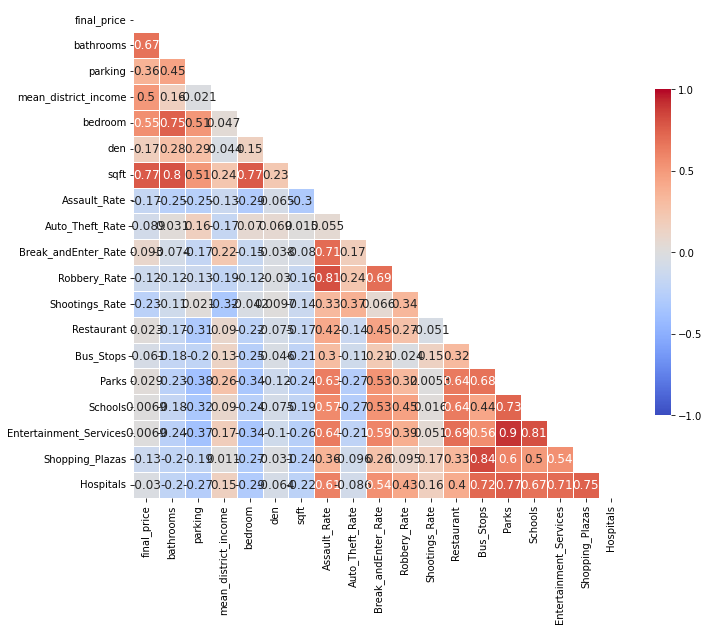

In [166]:
#Create Correlation matrix

corr_matrix = df_model[['final_price','bathrooms', 'parking','mean_district_income',
'bedroom', 'den', 'sqft','Assault_Rate',
'Auto_Theft_Rate','Break_andEnter_Rate','Robbery_Rate',
'Shootings_Rate','Restaurant','Bus_Stops','Parks','Schools',
'Entertainment_Services','Shopping_Plazas','Hospitals']].corr()

f, ax = plt.subplots(figsize=(11, 15))

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

### Modeling - Part 1 

In [167]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15234 entries, 0 to 15233
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              15234 non-null  int64  
 1   Unnamed: 0.1            15234 non-null  int64  
 2   final_price             15234 non-null  int64  
 3   bathrooms               15234 non-null  int64  
 4   parking                 15234 non-null  int64  
 5   description             15185 non-null  object 
 6   type                    15234 non-null  object 
 7   full_link               15234 non-null  object 
 8   full_address            15234 non-null  object 
 9   lat                     15234 non-null  float64
 10  long                    15234 non-null  float64
 11  city_district           15234 non-null  object 
 12  mean_district_income    15234 non-null  int64  
 13  district_code           15234 non-null  int64  
 14  bedroom                 15234 non-null

In [168]:
df_model.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'final_price', 'bathrooms', 'parking',
       'description', 'type', 'full_link', 'full_address', 'lat', 'long',
       'city_district', 'mean_district_income', 'district_code', 'bedroom',
       'den', 'sqft', 'OBJECTID', 'Neighbourhood', 'Hood_ID', 'Shape__Area',
       'Shape__Length', 'Assault_Rate', 'Auto_Theft_Rate',
       'Break_andEnter_Rate', 'Robbery_Rate', 'Shootings_Rate',
       'Neighbourhood_Coordin', 'Restaurant', 'Bus_Stops', 'Parks', 'Schools',
       'Entertainment_Services', 'Shopping_Plazas', 'Hospitals'],
      dtype='object')

In [303]:
X = df_model[['bathrooms', 'parking', 'type',
       'Neighbourhood','bedroom', 'den', 'sqft','mean_district_income',
     'Assault_Rate','Auto_Theft_Rate','Break_andEnter_Rate','Robbery_Rate',
       'Shootings_Rate','Restaurant','Bus_Stops','Parks','Schools',
             'Entertainment_Services','Shopping_Plazas','Hospitals']]

y = df_model[['final_price']]

In [441]:
X_crime = df_model[['bathrooms', 'parking', 'type',
       'Neighbourhood','bedroom', 'den', 'sqft','mean_district_income',
     'Assault_Rate','Auto_Theft_Rate','Break_andEnter_Rate','Robbery_Rate',
       'Shootings_Rate']]

y_crime = df_model[['final_price']]

In [442]:
#train test split

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_crime, y_crime, test_size=0.20, random_state = 42)

In [447]:
#Column Transformer and Creating Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['type','Neighbourhood']),
    ('scaler', MinMaxScaler(), ['bathrooms', 'parking','mean_district_income',
                                'bedroom', 'den', 'sqft','Assault_Rate',
                                'Auto_Theft_Rate','Break_andEnter_Rate','Robbery_Rate','Shootings_Rate'])])
#               'Restaurant','Bus_Stops','Parks','Schools','Entertainment_Services','Shopping_Plazas','Hospitals'])])


In [448]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

In [449]:
#parameters for gridsearch

base_model = LinearRegression()
ridge = Ridge()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
xgb = XGBRegressor()

models = [xgb]

params = [
#     {
#            'models':[ridge],
#            'models__alpha':[0.001,0.01,0.1,1,10]
#           },
#           {
#         'models':[rfr],
#         "models__n_estimators":[100, 150, 200],
#         "models__max_depth":[5,7, 10]
        
#     },
#     {
#         'models':[gbr],
#         "models__learning_rate":[0.1, 0.2, 0.3],
#         "models__n_estimators":[100, 150, 200],
#         "models__max_depth":[5,7, 10]
#     },
    {
        'models':[xgb],
        'models__learning_rate': [0.01, 0.1, 0.4, 0.8],
        'models__colsample_bytree': [0.6, 0.8, 1.0],
        'models__max_depth': [3, 5, 8, 12],
        'models__reg_alpha':[0,0.1,12.8, 51.2],
        'models__n_estimators':[200,300,500],
    }]

final_pipeline = Pipeline(steps = [('features',preprocessor),('models',xgb)])


In [450]:
#fitting gridsearchCV

gridsearch = GridSearchCV(final_pipeline, params,scoring = ['neg_mean_squared_error', 'r2'], verbose=5, refit = 'r2').fit(X_train, y_train)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-97329468591.271) r2: (test=0

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-81990305935.379) r2: (test=0.753) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-105937235305.598) r2: (test=0.754) total time=   0.2s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-77235083802.345) r2: (test=0.810) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-111583491308.761) r2: (test=0.765) total time=   0.3s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-58954521624.129) r2: (test=0.840) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-49250126850.603) r2: (test=0.852) total time=   0.4s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-82289827985.976) r2: (test=0.809) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-85242691384.269) r2: (test=0.790) total time=   0.4s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-89389905414.371) r2: (test=0.811) total time=   0.7s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-54899063357.144) r2: (test=0.851) total time=   0.6s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-46316751829.079) r2: (test=0.861) total time=   0.4s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-49319664309.582) r2: (test=0.885) total time=   0.7s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=500, models__reg_alpha=51.2; neg_mean_squared_error: (test=-58717360329.563) r2: (test=0.855) total time=   0.8s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-109540816708.883) r2: (test=0.769) total time=   0.7s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-74112204549.042) r2: (test=0.799) total time=   0.6s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-41300728761.041) r2: (test=0.876) total time=   0.9s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-50435360393.742) r2: (test=0.883) total time=   0.9s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=500, models__reg_alpha=0; neg_mean_squared_error: (test=-59176192679.882) r2: (test=0.854) total time=   1.7s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-69735796665.051) r2: (test=0.853) total time=   2.0s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-72500086388.379) r2: (test=0.803) total time=   1.5s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-63308886745.691) r2: (test=0.810) total time=   1.2s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-74823809697.517) r2: (test=0.826) total time=   1.2s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-58591765772.876) r2: (test=0.856) total time=   1.9s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-79020565515.315) r2: (test=0.833) total time=   1.7s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-46819314300.933) r2: (test=0.873) total time=   3.1s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-36186347902.411) r2: (test=0.891) total time=   3.6s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-48804939256.546) r2: (test=0.887) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-56931247564.382) r2: (test=0.860) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-71166447140.583) r2: (test=0.850) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-48749184455.771) r2: (test=0.868) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-40692165684.071) r2: (test=0.878) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-45131712157.396) r2: (test=0.895) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=500, models__reg_alpha=51.2; neg_mean_squared_error: (test=-55534800150.613) r2: (test=0.863) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-68447187246.755) r2: (test=0.856) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-45377683928.357) r2: (test=0.877) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-36277014557.981) r2: (test=0.891) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-45449234939.300) r2: (test=0.894) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=500, models__reg_alpha=0; neg_mean_squared_error: (test=-65338017174.417) r2: (test=0.839) total time=   0.8s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-66453521846.588) r2: (test=0.860) total time=   0.7s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-49134945591.475) r2: (test=0.866) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-35880184358.764) r2: (test=0.892) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-45525038088.671) r2: (test=0.894) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-65695341805.787) r2: (test=0.838) total time=   0.7s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-65838020308.617) r2: (test=0.861) total time=   0.7s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-51038258621.178) r2: (test=0.861) total time=   1.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-35819632648.331) r2: (test=0.892) total time=   1.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-46952232591.303) r2: (test=0.891) total time=   0.9s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-65861159612.917) r2: (test=0.838) total time=   0.9s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-70049279340.000) r2: (test=0.852) total time=   1.4s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-54785247229.678) r2: (test=0.851) total time=   1.3s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-38335123863.274) r2: (test=0.885) total time=   1.3s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-48218749025.826) r2: (test=0.888) total time=   2.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=500, models__reg_alpha=51.2; neg_mean_squared_error: (test=-66097554972.244) r2: (test=0.837) total time=   2.6s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-64333388122.291) r2: (test=0.864) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-46078064377.028) r2: (test=0.875) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-39052894683.086) r2: (test=0.883) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-47605069164.208) r2: (test=0.889) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=500, models__reg_alpha=0; neg_mean_squared_error: (test=-64369546712.868) r2: (test=0.841) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-62122384060.359) r2: (test=0.869) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-50787864072.388) r2: (test=0.862) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-37709527737.375) r2: (test=0.887) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-48770524426.095) r2: (test=0.887) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-75355569947.556) r2: (test=0.814) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-68731851266.399) r2: (test=0.855) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-52648060675.463) r2: (test=0.857) total time=   0.8s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-39167657706.682) r2: (test=0.882) total time=   0.8s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-61396151510.484) r2: (test=0.857) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-84171996894.359) r2: (test=0.793) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-75863586735.461) r2: (test=0.840) total time=   0.8s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-60672125078.136) r2: (test=0.835) total time=   0.8s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-49453668369.587) r2: (test=0.851) total time=   0.9s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-62713138621.380) r2: (test=0.854) total time=   1.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=500, models__reg_alpha=51.2; neg_mean_squared_error: (test=-84277265100.596) r2: (test=0.792) total time=   1.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-81833633664.903) r2: (test=0.827) total time=   0.9s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-64301103245.570) r2: (test=0.825) total time=   1.1s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-51301058499.817) r2: (test=0.846) total time=   1.4s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-64671786082.280) r2: (test=0.850) total time=   1.5s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=500, models__reg_alpha=0; neg_mean_squared_error: (test=-79618147400.329) r2: (test=0.804) total time=   2.7s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-82203813303.911) r2: (test=0.827) total time=   2.6s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-62040854774.977) r2: (test=0.831) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-49651222202.068) r2: (test=0.851) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-55722920473.075) r2: (test=0.871) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-74349120673.571) r2: (test=0.817) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-68110197044.022) r2: (test=0.856) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-68614987443.911) r2: (test=0.814) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-49049153842.027) r2: (test=0.852) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-69612751359.539) r2: (test=0.838) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-84924408224.169) r2: (test=0.791) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-73319640220.693) r2: (test=0.845) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-72490480837.810) r2: (test=0.803) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-57597502504.555) r2: (test=0.827) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-70753452835.904) r2: (test=0.836) total time=   0.9s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=500, models__reg_alpha=51.2; neg_mean_squared_error: (test=-86166676005.095) r2: (test=0.788) total time=   0.8s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-91584521084.407) r2: (test=0.807) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-76627930485.753) r2: (test=0.792) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-66033375862.324) r2: (test=0.801) total time=   0.8s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-89428038162.940) r2: (test=0.792) total time=   0.8s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=500, models__reg_alpha=0; neg_mean_squared_error: (test=-91014266426.756) r2: (test=0.776) total time=   1.4s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-93464706618.481) r2: (test=0.803) total time=   1.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-81962767879.255) r2: (test=0.777) total time=   1.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-73522841641.606) r2: (test=0.779) total time=   1.0s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-93194875993.853) r2: (test=0.784) total time=   1.2s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-84417148279.976) r2: (test=0.792) total time=   1.5s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-110662518894.541) r2: (test=0.767) total time=   1.7s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-82010389956.017) r2: (test=0.777) total time=   2.9s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-74013749600.932) r2: (test=0.777) total time=   3.0s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-104291592702.166) r2: (test=0.758) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-108206156781.100) r2: (test=0.733) total time=   0.2s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-110164375669.790) r2: (test=0.768) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-71097829766.361) r2: (test=0.807) total time=   0.3s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-58012161498.788) r2: (test=0.826) total time=   0.3s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-62685659485.084) r2: (test=0.854) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=500, models__reg_alpha=51.2; neg_mean_squared_error: (test=-69680997243.382) r2: (test=0.828) total time=   0.6s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-118521513513.907) r2: (test=0.750) total time=   0.4s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-78517329768.008) r2: (test=0.787) total time=   0.4s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-46043894606.595) r2: (test=0.862) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-58929811657.135) r2: (test=0.863) total time=   0.6s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=500, models__reg_alpha=0; neg_mean_squared_error: (test=-63416511653.238) r2: (test=0.844) total time=   1.2s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-76900127985.303) r2: (test=0.838) total time=   1.0s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-72397287225.129) r2: (test=0.803) total time=   0.7s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-61806157229.519) r2: (test=0.814) total time=   0.8s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-70285275816.790) r2: (test=0.837) total time=   0.8s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-61037654093.288) r2: (test=0.850) total time=   1.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-82367728995.809) r2: (test=0.826) total time=   1.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-48945291369.271) r2: (test=0.867) total time=   2.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-36389322894.458) r2: (test=0.891) total time=   1.9s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-71742428314.205) r2: (test=0.833) total time=   1.4s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-78710272743.085) r2: (test=0.806) total time=   1.4s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-81210668744.791) r2: (test=0.829) total time=   2.3s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-51081498884.296) r2: (test=0.861) total time=   2.3s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-40427164331.020) r2: (test=0.878) total time=   2.2s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-49447927765.191) r2: (test=0.885) total time=   4.3s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=500, models__reg_alpha=51.2; neg_mean_squared_error: (test=-64984472652.046) r2: (test=0.840) total time=   3.6s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-72346975272.406) r2: (test=0.847) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-53440294718.323) r2: (test=0.855) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-40678639695.648) r2: (test=0.878) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-46680610565.704) r2: (test=0.892) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=500, models__reg_alpha=0; neg_mean_squared_error: (test=-60217304914.459) r2: (test=0.852) total time=   0.6s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=500, models__reg_alpha=12.8; neg_mean_squared_error: (test=-64987295309.504) r2: (test=0.863) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-45878804596.986) r2: (test=0.875) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-35930818743.574) r2: (test=0.892) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-45356498734.147) r2: (test=0.895) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-66073340763.121) r2: (test=0.837) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-67385589975.824) r2: (test=0.858) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=500, models__reg_alpha=0.1; neg_mean_squared_error: (test=-45717763225.230) r2: (test=0.876) total time=   0.8s
[CV 2/5] END models=XGBRegressor(base_

KeyboardInterrupt: 

In [ ]:
print('Final training score is: ', gridsearch.score(X_train, y_train))

In [ ]:
print('Final score is: ', gridsearch.score(X_test, y_test))

In [ ]:
y_pred = gridsearch.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print('RMSE is',rmse)
print('MAE is',mae)

In [383]:
gridsearch.best_params_

{'models': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=0.1, reg_lambda=None, ...),
 'models__colsample_bytree': 0.6,
 'models__learning_rate': 0.1,
 'models__max_depth': 3,
 'models__n_estimators': 500,
 'models__reg_alpha': 0.1}

In [384]:
feature_imp = gridsearch.best_estimator_.named_steps['models'].feature_importances_

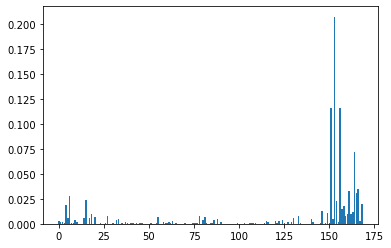

In [385]:
# plot
plt.bar(range(len(gridsearch.best_estimator_.named_steps['models'].feature_importances_)), gridsearch.best_estimator_.named_steps['models'].feature_importances_)
plt.show()

In [196]:
# Fit model using each importance as a threshold
thresholds = sorted(feature_imp, key=lambda x: x)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(gridsearch.best_estimator_.named_steps['models'], threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = gridsearch
    selection_model.fit(X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


ValueError: X has a different shape than during fitting.

In [197]:
selection

SelectFromModel(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=0.6,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.1, max_bin=256,
                                       max_cat_to_onehot=4, max_delta_step=0,
                                       max_depth=3, max_leaves=0,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                

#### Saving Models and Pipeline

In [198]:
#pickling dropNaN, XGBoost base model

import pickle
with open('best_KNN_test.pickle', 'wb') as f:
    pickle.dump(gridsearch, f)

In [319]:
import joblib
joblib.dump(gridsearch.best_estimator_, 'best_KNN_test_joblib.pickle', compress = 1)

['best_KNN_test_joblib.pickle']

In [342]:
def predictor(data):
    
    #load model
    file3 = open("best_KNN_test_joblib.pickle",'rb')
    model_joblib = joblib.load(file3)
    

    X = df_model[['bathrooms', 'parking', 'type',
       'Neighbourhood','bedroom', 'den', 'sqft','mean_district_income',
     'Assault_Rate','Auto_Theft_Rate','Break_andEnter_Rate','Robbery_Rate',
       'Shootings_Rate','Restaurant','Bus_Stops','Parks','Schools',
             'Entertainment_Services','Shopping_Plazas','Hospitals']]
    
    cols = ['mean_district_income','Assault_Rate','Auto_Theft_Rate','Break_andEnter_Rate','Robbery_Rate',
       'Shootings_Rate','Restaurant','Bus_Stops','Parks','Schools',
             'Entertainment_Services','Shopping_Plazas','Hospitals','Neighbourhood']

    x_test = pd.DataFrame(data, columns=['bathrooms', 'parking', 'type', 'Neighbourhood',
       'bedroom', 'den', 'sqft'])

    x_test = pd.merge(x_test, X[cols], on = ['Neighbourhood'], how = 'inner')
    
    return model_joblib.predict(x_test)

In [343]:
data = [[2, 1, 'Condo Apt','Bay Street Corridor', 2, 1, 850]]
predictor(data)

array([940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 940183.3,
       940183.3, 940183.3, 940183.3, 940183.3, 940183.3, 94018

In [344]:
print(sklearn.__version__)

0.24.2
